# LSTM

In [ ]:
# Import necessary packages
import time
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
# Mount Device
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
%cd '/content/gdrive/MyDrive/ECSE_552/Project'

## Data Preparation

In [ ]:
# Import the dataset
df = pd.read_csv('data/ON_demand_weather_17-20.csv', index_col=0)


# Do all the preprocessing required
from preprocessing.preprocessing import one_hot_encode_days, one_hot_encode_months, time_differencing, split_and_scale, sin_cos_waves, sliding_windows


# Remove weather stations and market demand columns
df.drop(['Market Demand',
         'toronto_Temp (C)',
         'hamilton_Temp (C)',
         'ottawa_Temp (C)',
         'kitchener_Temp (C)',
         'london_Temp (C)',
         'windsor_Temp (C)'], axis=1, inplace=True)
df = sin_cos_waves(df, lst_of_freq=['HalfDay', 'Day', 'Week', 'TwoYears'], drop_datetime_columns=True)

# Apply scaling if desired and split dataset into train, validation, and testset

scaler = 'standard'  # Define the type of scaler, options are 'min-max', 'standard', and None
columns_to_scale = list(df.columns) # Define columns to be scaled, add time-differenced column if applicable
columns_to_scale.remove('Date')
columns_to_scale.remove('Holiday')
target_column = 'Ontario Demand'  # Define target column (required to allow unscaling later), change to time-differenced column if applicable
vali_set_start_date='2019-07-01'  # First day of validation set
test_set_start_date='2020-01-01'  # First day of test set

train_df, vali_df, test_df, target_scaler = split_and_scale(df,
                                                            scaler=scaler,
                                                            columns_to_scale=columns_to_scale,
                                                            target_column=target_column,
                                                            vali_set_start_date=vali_set_start_date,
                                                            test_set_start_date=test_set_start_date)

## Model Training and Evaluation

#### 1Hour Predictions

In [ ]:
# Grid Search Parameters
window_sizes = [18, 24, 36, 48]
perform_feature_shifts = [1, False]
n_neurons = [64, 96, 128]
n_layers = [1]
result_dic = {"window_size":[], "perform_feature_shift":[], "n_neurons": [], "n_layers":[], "loss_scaled":[], "loss_unscaled":[]}

In [ ]:
for window_size in window_sizes:
  for perform_feature_shift in perform_feature_shifts:
    window_size = window_size
    flatten = False
    output_window_size = 1
    perform_feature_shift = perform_feature_shift

    # note that the function removes the 'Date' column (not numeric)
    x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    # repeat function call for validation and test data

    # Batch and shuffle datasets
    SHUFFLE_BUFFER_SIZE = 100
    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
    
    for n_neuron in n_neurons:
      for n_layer in n_layers:
        LSTM_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(n_neuron, return_sequences=False),
                                                tf.keras.layers.Dense(units=1)])

        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
        # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/ECSE_552/Project/Checkpoints', save_weights_only=True)

        LSTM_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
        history = LSTM_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

        loss_fun = RMSELoss()
        y_pred = LSTM_model.predict(x_vali)
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        y_vali_tensor = torch.from_numpy(y_vali)
        y_pred_tensor = torch.from_numpy(y_pred)
        unscaled_y_pred = torch.from_numpy(target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
        unscaled_target = torch.from_numpy(target_scaler.inverse_transform(y_vali.reshape(-1, 1)))
        loss_fun = RMSELoss()
        loss_unscaled = loss_fun(unscaled_y_pred, unscaled_target)
        loss_scaled = loss_fun(y_pred_tensor, y_vali_tensor)
        # print("Unscaled loss: {}".format(loss_unscaled))
        # print("Scaled loss: {}".format(loss_scaled))

        # Append to dictionary
        result_dic['window_size'].append(window_size)
        result_dic['perform_feature_shift'].append(perform_feature_shift)
        result_dic['n_neurons'].append(n_neuron)
        result_dic['n_layers'].append(n_layer)
        result_dic['loss_scaled'].append(loss_scaled)
        result_dic['loss_unscaled'].append(loss_unscaled)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
Epoch 1/500
683/683 [==============================] - 36s 5ms/step - loss: 0.1294 - val_loss: 0.0457
Epoch 2/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0205 - val_loss: 0.0285
Epoch 3/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0135 - val_loss: 0.0217
Epoch 4/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0099 - val_loss: 0.0168
Epoch 5/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0080 - val_loss: 0.0137
Epoch 6/500
683/683 [==============================] - 3s 4ms/step - loss: 0.007

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df['loss_scaled'] = result_df['loss_scaled'].apply(lambda x: x.item())
result_df['loss_unscaled'] = result_df['loss_unscaled'].apply(lambda x: x.item())
result_df

,window_size,perform_feature_shift,n_neurons,n_layers,loss_scaled,loss_unscaled
0,12,False,32,1,0.075788,169.988129
1,12,False,64,1,0.069248,155.318354
2,12,False,96,1,0.071330,159.988874
3,12,False,128,1,0.072487,162.583402
4,12,1,32,1,0.070686,158.544353
5,12,1,64,1,0.067454,151.295371
6,12,1,96,1,0.067367,151.099861
7,12,1,128,1,0.067553,151.518530
8,18,False,32,1,0.071709,160.839695
9,18,False,64,1,0.071643,160.691782


In [ ]:
result_df.to_csv('TrainingResults/LSTM_STDScaleNoHoliday_NewShift_TF.csv')

#### 24Hour Sequence Predictions

In [ ]:
# Grid Search Parameters
window_sizes = [24, 48]
perform_feature_shifts = [24, False]
n_neurons = [64, 96, 128]
n_layers = [1]
output_window_size=24
flatten=False
result_dic = {"window_size":[], "perform_feature_shift":[], "n_neurons": [], "n_layers":[], "loss_scaled":[], "loss_unscaled":[]}

In [ ]:
for window_size in window_sizes:
  for perform_feature_shift in perform_feature_shifts:

    # note that the function removes the 'Date' column (not numeric)
    x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    # repeat function call for validation and test data

    SHUFFLE_BUFFER_SIZE = 100
    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
    for n_neuron in n_neurons:
      for n_layer in n_layers:
        LSTMSeq_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(n_neuron, return_sequences=False),
                                                tf.keras.layers.Dense(units=24),
                                                tf.keras.layers.Reshape([24, 1])])

        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        LSTMSeq_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
        history = LSTMSeq_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

        loss_fun = RMSELoss()
        y_pred = LSTMSeq_model.predict(x_vali)
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        y_vali_tensor = torch.from_numpy(y_vali)
        y_pred_tensor = torch.from_numpy(y_pred)
        unscaled_y_pred = torch.from_numpy(target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
        unscaled_target = torch.from_numpy(target_scaler.inverse_transform(y_vali.reshape(-1, 1)))
        loss_fun = RMSELoss()
        loss_unscaled = loss_fun(unscaled_y_pred, unscaled_target)
        loss_scaled = loss_fun(y_pred_tensor, y_vali_tensor)

        # Append to dictionary
        result_dic['window_size'].append(window_size)
        result_dic['perform_feature_shift'].append(perform_feature_shift)
        result_dic['n_neurons'].append(n_neuron)
        result_dic['n_layers'].append(n_layer)
        result_dic['loss_scaled'].append(loss_scaled)
        result_dic['loss_unscaled'].append(loss_unscaled)

------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 6s 6ms/step - loss: 0.2300 - val_loss: 0.1998
Epoch 2/500
682/682 [==============================] - 4s 5ms/step - loss: 0.1271 - val_loss: 0.1729
Epoch 3/500
682/682 [==============================] - 4s 6ms/step - loss: 0.1104 - val_loss: 0.1578
Epoch 4/500
682/682 [==============================] - 4s 6ms/step - loss: 0.1044 - val_loss: 0.1520
Epoch 5/500
682/682 [==============================] - 4s 6ms/step - loss: 0.0985 - val_loss: 0.1506
Epoch 6/500
682/682 [==============================] - 4s 5ms/step - loss: 0.0

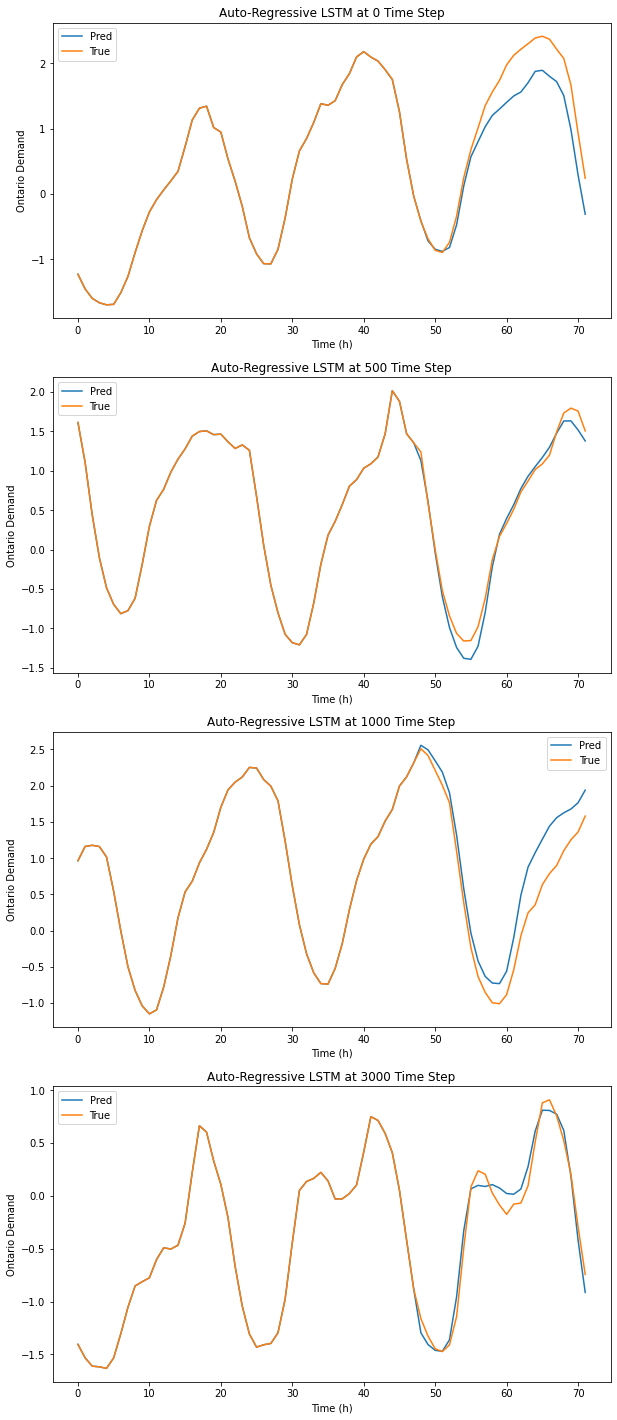

In [ ]:
predictions = []
for i in [0, 500, 1000, 3000]:
  pred = LSTM_model.predict(x_vali[i].reshape(1, x_vali[i].shape[0], x_vali[i].shape[1]))
  pred = pred.reshape(pred.shape[1])
  predictions.append(pred)
# Pressure test results
j = 0
fig, ax = plt.subplots(4, 1,  figsize=(10, 25))
for i in [0, 500, 1000, 3000]:
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], predictions[j]]), label='Pred')
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], y_vali[i]]), label='True')
  ax[j].legend()
  ax[j].set_xlabel('Time (h)')
  ax[j].set_ylabel('Ontario Demand')
  ax[j].set_title('Auto-Regressive LSTM at {} Time Step'.format(i))
  j += 1
plt.show()

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df['loss_scaled'] = result_df['loss_scaled'].apply(lambda x: x.item())
result_df['loss_unscaled'] = result_df['loss_unscaled'].apply(lambda x: x.item())
result_df.to_csv('TrainingResults/LSTM_Seqence_TF.csv')

#### 24Hour AutoRegressive Predictions

In [ ]:
# Grid Search Parameters
window_sizes = [24, 48]
perform_feature_shifts = [1, False]
n_neurons = [64, 96, 128]
n_layers = [1]
output_window_size=24
flatten = False
result_dic = {"window_size":[], "perform_feature_shift":[], "n_neurons": [], "n_layers":[], "loss_scaled":[], "loss_unscaled":[]}

In [ ]:
for window_size in window_sizes:
  for perform_feature_shift in perform_feature_shifts:
    

    # Sliding windows
    # note that the function removes the 'Date' column (not numeric)
    x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
    x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
    x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
    # repeat function call for validation and test data

    SHUFFLE_BUFFER_SIZE = 100
    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
    for n_neuron in n_neurons:
      for n_layer in n_layers:
        class ARLSTM(tf.keras.Model):
          def __init__(self, units, out_steps):
            super().__init__()
            self.out_steps = out_steps
            self.units = units
            self.LSTM_cell = tf.keras.layers.LSTMCell(units)
            # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
            self.LSTM_rnn = tf.keras.layers.RNN(self.LSTM_cell, return_state=True)
            self.dense = tf.keras.layers.Dense(1)
          
          def warmup(self, inputs):
            # inputs.shape => (batch, time, features)
            # x.shape => (batch, LSTM_units)
            x, *state = self.LSTM_rnn(inputs)

            # predictions.shape => (batch, features)
            prediction = self.dense(x)
            return prediction, state

          def call(self, inputs, training=None):
            warmup_input = inputs[:, :-self.out_steps, :]
            out_input = inputs[:, -self.out_steps:, :]
            # Use a TensorArray to capture dynamically unrolled outputs.
            predictions = []
            # Initialize the LSTM state
            prediction, state = self.warmup(warmup_input)
            
            # Insert the first prediction
            predictions.append(prediction)

            # Run the rest of the prediction steps
            for n in range(self.out_steps - 1):
              # Use the last electricity prediction as part of the input
              x = tf.concat([out_input[:, n, :-1], prediction], -1)
              # Execute one LSTM step.
              x, state = self.LSTM_cell(x, states=state,
                                        training=training)
              # Convert the LSTM output to a prediction.
              prediction = self.dense(x)
              # Add the prediction to the output
              predictions.append(prediction)

            # predictions.shape => (time, batch, features)
            predictions = tf.stack(predictions)
            # predictions.shape => (batch, time, features)
            predictions = tf.transpose(predictions, [1, 0, 2])
            return predictions

        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        ARLSTM_model = ARLSTM(n_neuron, output_window_size)
        ARLSTM_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
        history = ARLSTM_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

        loss_fun = RMSELoss()
        y_pred = ARLSTM_model.predict(x_vali)
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        y_vali_tensor = torch.from_numpy(y_vali)
        y_pred_tensor = torch.from_numpy(y_pred)
        unscaled_y_pred = torch.from_numpy(target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
        unscaled_target = torch.from_numpy(target_scaler.inverse_transform(y_vali.reshape(-1, 1)))
        loss_fun = RMSELoss()
        loss_unscaled = loss_fun(unscaled_y_pred, unscaled_target)
        loss_scaled = loss_fun(y_pred_tensor, y_vali_tensor)

        # Append to dictionary
        result_dic['window_size'].append(window_size)
        result_dic['perform_feature_shift'].append(perform_feature_shift)
        result_dic['n_neurons'].append(n_neuron)
        result_dic['n_layers'].append(n_layer)
        result_dic['loss_scaled'].append(loss_scaled)
        result_dic['loss_unscaled'].append(loss_unscaled)

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df['loss_scaled'] = result_df['loss_scaled'].apply(lambda x: x.item())
result_df['loss_unscaled'] = result_df['loss_unscaled'].apply(lambda x: x.item())
result_df.to_csv('TrainingResults/LSTM_Autoregressive_TF.csv')

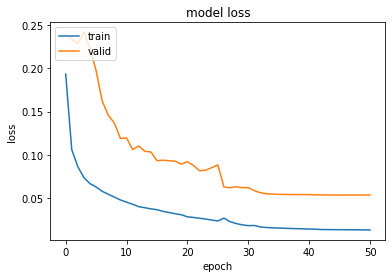

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
predictions = []
for i in [0, 500, 1000, 3000]:
  pred = ARLSTM_model.predict(x_vali[i].reshape(1, x_vali[i].shape[0], x_vali[i].shape[1]))
  pred = pred.reshape(pred.shape[1])
  predictions.append(pred)

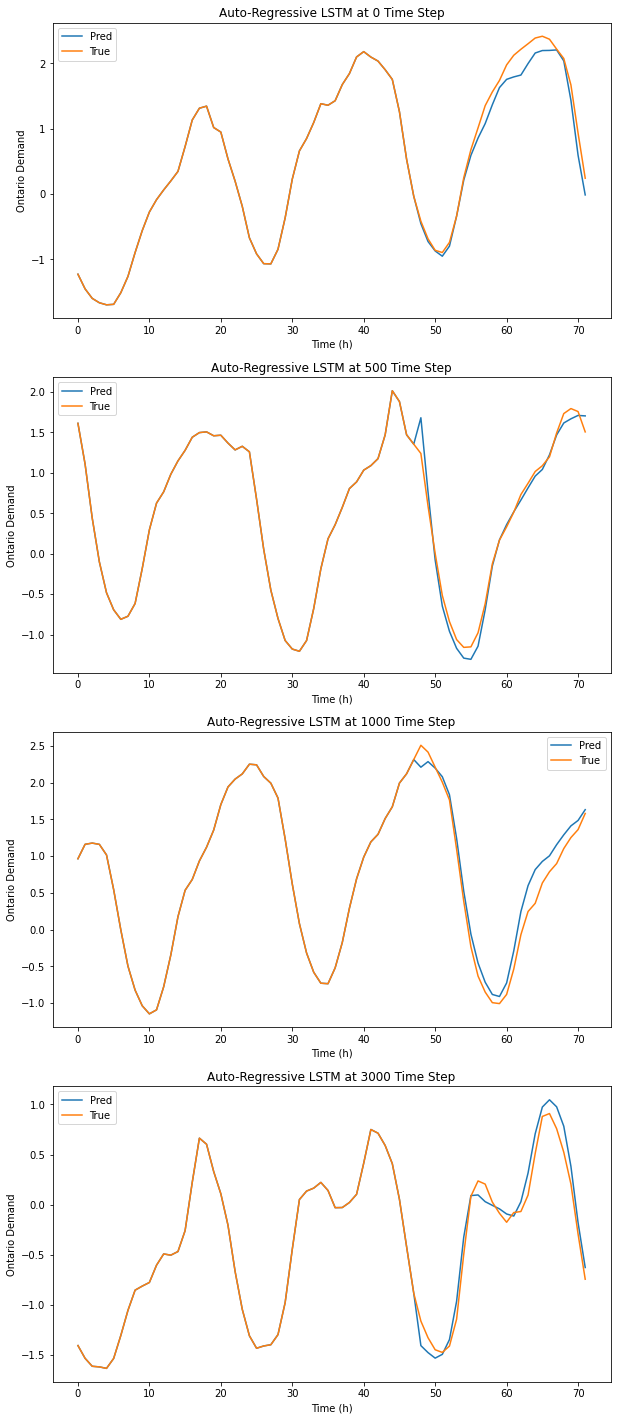

In [ ]:
# Pressure test results
j = 0
fig, ax = plt.subplots(4, 1,  figsize=(10, 25))
for i in [0, 500, 1000, 3000]:
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], predictions[j]]), label='Pred')
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], y_vali[i]]), label='True')
  ax[j].legend()
  ax[j].set_xlabel('Time (h)')
  ax[j].set_ylabel('Ontario Demand')
  ax[j].set_title('Auto-Regressive LSTM at {} Time Step'.format(i))
  j += 1
plt.show()

### Test Phase

Models to test:
- LSTM 1h: 24 window size, 96 neurons, shift/non-shift
- LSTM 24h autoregressive: 48 window size, 64 neuron, shift/non-shift
- LSTM 24h sequence: 24 window size, 128 neuron, shift/non-shift

In [ ]:
window_sizes = [24]
perform_feature_shifts = [1, False]
n_neurons = [96]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:
      window_size = window_size
      flatten = False
      output_window_size = 1
      perform_feature_shift = perform_feature_shift

      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          LSTM_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(n_neuron, return_sequences=False),
                                                  tf.keras.layers.Dense(units=1)])

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
          # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/ECSE_552/Project/Checkpoints', save_weights_only=True)

          LSTM_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = LSTM_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = LSTM_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred, y_test))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
Epoch 1/500
683/683 [==============================] - 5s 5ms/step - loss: 0.1197 - val_loss: 0.0451
Epoch 2/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0199 - val_loss: 0.0283
Epoch 3/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0131 - val_loss: 0.0200
Epoch 4/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0100 - val_loss: 0.0154
Epoch 5/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0081 - val_loss: 0.0126
Epoch 6/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0071

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,1,0.085440,191.637360,36.090354,0.944581
1,1,False,0.084559,189.661118,35.759859,0.937609
2,2,1,0.084939,190.513245,55.353813,0.942129
3,2,False,0.084933,190.499084,41.601583,0.945199
4,3,1,0.086404,193.798309,34.779162,0.956628
5,3,False,0.103071,231.182907,37.319971,1.160898
6,4,1,0.090326,202.596832,31.972381,0.989905
7,4,False,0.084901,190.427475,26.900767,0.942465
8,5,1,0.086281,193.524109,45.445991,0.946688
9,5,False,0.088571,198.658768,43.201147,0.984629


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.089207,200.085870,36.956665,0.994160
1,3,0.086678,194.413971,40.728340,0.955986


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.007922,17.768855,6.388549,0.095079
1,1.581139,0.002127,4.771146,9.614197,0.019745


In [ ]:
result_df.to_csv("TrainingResults/LSTM_1h_TestResults.csv")

In [ ]:
window_sizes = [48]
perform_feature_shifts = [1, False]
n_neurons = [96]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
output_window_size=24
flatten = False
for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:
      # Sliding windows
      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          class ARLSTM(tf.keras.Model):
            def __init__(self, units, out_steps):
              super().__init__()
              self.out_steps = out_steps
              self.units = units
              self.LSTM_cell = tf.keras.layers.LSTMCell(units)
              # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
              self.LSTM_rnn = tf.keras.layers.RNN(self.LSTM_cell, return_state=True)
              self.dense = tf.keras.layers.Dense(1)
            
            def warmup(self, inputs):
              # inputs.shape => (batch, time, features)
              x, *state = self.LSTM_rnn(inputs)

              # predictions.shape => (batch, features)
              prediction = self.dense(x)
              return prediction, state

            def call(self, inputs, training=None):
              warmup_input = inputs[:, :-self.out_steps, :]
              out_input = inputs[:, -self.out_steps:, :]
              # Use a TensorArray to capture dynamically unrolled outputs.
              predictions = []
              # Initialize the LSTM state
              prediction, state = self.warmup(warmup_input)
              # Insert the first prediction
              predictions.append(prediction)

              # Run the rest of the prediction steps
              for n in range(self.out_steps - 1):
                # Use the last electricity prediction as part of the input
                x = tf.concat([out_input[:, n, :-1], prediction], -1)
                # Execute one LSTM step.
                x, state = self.LSTM_cell(x, states=state,
                                          training=training)
                # Convert the LSTM output to a prediction.
                prediction = self.dense(x)
                # Add the prediction to the output
                predictions.append(prediction)

              # predictions.shape => (time, batch, features)
              predictions = tf.stack(predictions)
              # predictions.shape => (batch, time, features)
              predictions = tf.transpose(predictions, [1, 0, 2])
              return predictions

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

          ARLSTM_model = ARLSTM(n_neuron, output_window_size)
          ARLSTM_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = ARLSTM_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = ARLSTM_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred.reshape(-1,1), y_test.reshape(-1, 1)))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 65s 88ms/step - loss: 0.2476 - val_loss: 0.2841
Epoch 2/500
682/682 [==============================] - 59s 86ms/step - loss: 0.1124 - val_loss: 0.2453
Epoch 3/500
682/682 [==============================] - 59s 86ms/step - loss: 0.0893 - val_loss: 0.2473
Epoch 4/500
682/682 [==============================] - 59s 87ms/step - loss: 0.0806 - val_loss: 0.2698
Epoch 5/500
682/682 [==============================] - 59s 87ms/step - loss: 0.0749 - val_loss: 0.2

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,1,0.310773,697.047546,241.251879,3.464969
1,1,False,0.343352,770.120178,335.777011,4.024692
2,2,1,0.316040,708.859924,307.191457,3.569088
3,2,False,0.331279,743.039368,342.090488,3.800389
4,3,1,0.321324,720.711792,277.128067,3.585742
5,3,False,0.304710,683.448486,324.611460,3.491510
6,4,1,0.314094,704.495972,320.606518,3.536506
7,4,False,0.325120,729.226013,333.762638,3.636638
8,5,1,0.363561,815.446899,286.983754,4.254546
9,5,False,0.338679,759.637451,382.688148,4.021060


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.328628,737.094299,343.785949,3.794858
1,3,0.325158,729.312427,286.632335,3.682170


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.015077,33.815785,22.630326,0.235093
1,1.581139,0.021806,48.908849,30.523609,0.323301


In [ ]:
result_df.to_csv('TrainingResults/LSTM_AR_TestResult.csv')

In [ ]:
window_sizes = [24]
perform_feature_shifts = [24, False]
n_neurons = [128]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
output_window_size=24
flatten = False

for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:

      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          LSTMSeq_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(n_neuron, return_sequences=False),
                                                  tf.keras.layers.Dense(units=24),
                                                  tf.keras.layers.Reshape([24, 1])])

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

          LSTMSeq_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = LSTMSeq_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = LSTMSeq_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred.reshape(-1, 1), y_test.reshape(-1, 1)))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 33s 5ms/step - loss: 0.2584 - val_loss: 0.2115
Epoch 2/500
682/682 [==============================] - 3s 4ms/step - loss: 0.1205 - val_loss: 0.1676
Epoch 3/500
682/682 [==============================] - 3s 4ms/step - loss: 0.1103 - val_loss: 0.1549
Epoch 4/500
682/682 [==============================] - 3s 4ms/step - loss: 0.1046 - val_loss: 0.1511
Epoch 5/500
682/682 [==============================] - 3s 4ms/step - loss: 0.0975 - val_loss: 0.1518
Epoch 6/500
682/682 [==============================] - 3s 4ms/step - loss: 0.

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,24,0.356014,798.518921,263.338461,3.729566
1,1,False,0.360434,808.433350,284.876774,3.771348
2,2,24,0.358672,804.482056,244.342235,3.753532
3,2,False,0.357125,801.010925,341.913928,3.817960
4,3,24,0.347871,780.254578,345.816626,3.747763
5,3,False,0.345638,775.247559,260.512299,3.731303
6,4,24,0.360055,807.584534,273.097389,3.744222
7,4,False,0.353504,792.889893,253.833934,3.735006
8,5,24,0.349514,783.940857,865.072859,3.715874
9,5,False,0.349280,783.415466,307.024599,3.796276


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.353196,792.199438,289.632307,3.770378
24,3,0.354425,794.956189,398.333514,3.738191


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.005924,13.287055,36.013793,0.037795
24,1.581139,0.005462,12.251380,263.735049,0.015295


In [ ]:
result_df.to_csv('TrainingResults/LSTM_Seq_TestResult.csv')